# Set-up

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [12]:
path_out = "/cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/analysis/"

# Load data

In [94]:
path_rna = "/cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/processed/2024_05_19/GSE126074_CellLineMixture_SNAREseq_cDNA_counts.tsv.gz"
path_atac = "/cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/processed/2024_05_19/GSE126074_CellLineMixture_SNAREseq_chromatin_counts.tsv.gz"

In [117]:
rna_mat = pd.read_csv(path_rna, sep="\t", index_col=0)
atac_mat = pd.read_csv(path_atac, sep="\t", index_col=0)

In [200]:
rna = ad.AnnData(X=rna_mat.T, obs=pd.DataFrame(index=rna_mat.columns), var=pd.DataFrame(index=rna_mat.index))
atac = ad.AnnData(X=atac_mat.T, obs=pd.DataFrame(index=atac_mat.columns), var=pd.DataFrame(index=atac_mat.index))

In [201]:
# Save base AnnData objects
rna.write(path_out + "rna.h5ad")
atac.write(path_out + "atac.h5ad")

# RNA analysis

In [202]:
rna.layers["counts"] = rna.X.copy()

In [203]:
sc.pp.calculate_qc_metrics(rna, inplace=True)

In [204]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
rna.layers["log1p_norm"] = rna.X.copy()

In [205]:
sc.pp.scale(rna, max_value=10)
rna.layers["scaled"] = rna.X.copy()

In [206]:
# Run PCA
sc.pp.pca(rna, n_comps=50, random_state=1234)

In [207]:
# Run neighbors
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=50, random_state=1234)

In [208]:
# Run UMAP
sc.tl.umap(rna, min_dist=0.3, spread=1.0, random_state=1234)

In [209]:
# Run Leiden clustering
sc.tl.leiden(rna, resolution=0.2, random_state=1234)

In [210]:
markers = {
    "BJ": "JUN", 
    "GM12878": "IRF8", 
    "H1": "POU5F1",
    "K562": "GATA1"
}

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


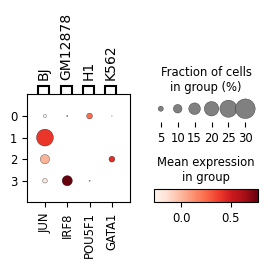

In [211]:
# Plot dotplot
sc.pl.dotplot(rna, markers, groupby="leiden")

In [212]:
annotation = {
    "0": "H1",
    "1": "BJ",
    "2": "K562",
    "3": "GM12878"
}

In [213]:
#
rna.obs["annotation"] = rna.obs["leiden"].map(annotation)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


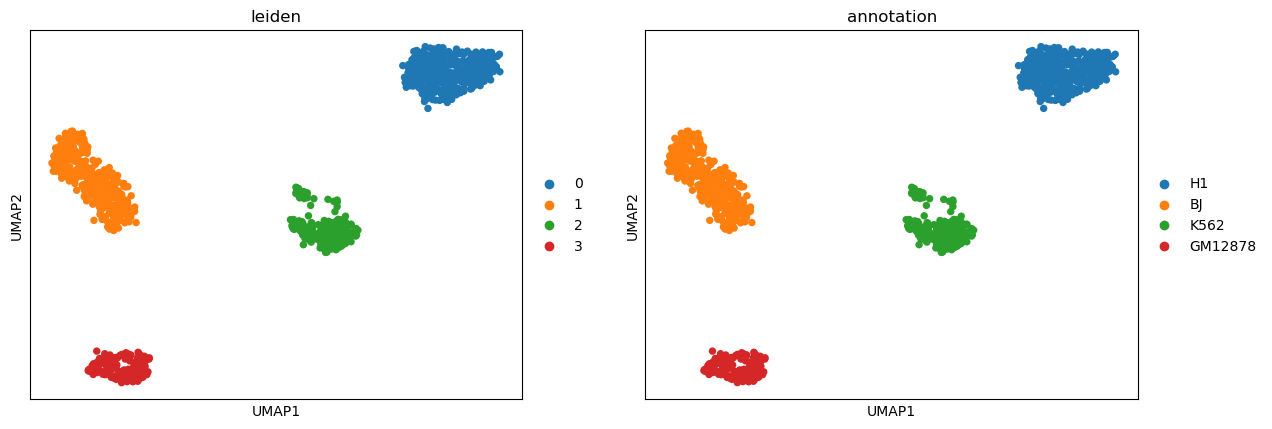

In [214]:
# Plot UMAP
sc.pl.umap(rna, color=["leiden", "annotation"])

In [215]:
rna.obs["annotation"].to_csv(path_out + "annotations.tsv", sep="\t", header=False)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


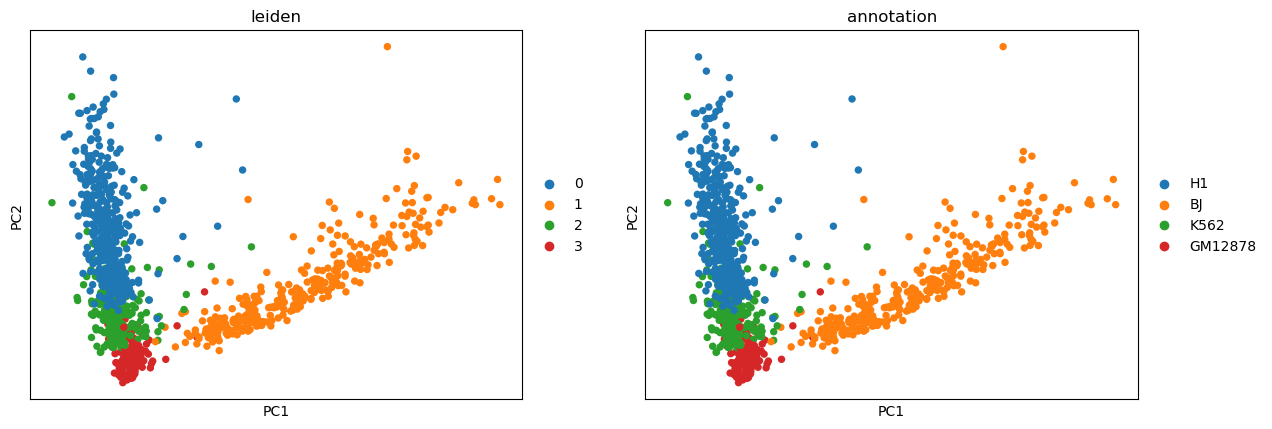

In [216]:
# Plot PCA
sc.pl.pca(rna, color=["leiden", "annotation"])

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


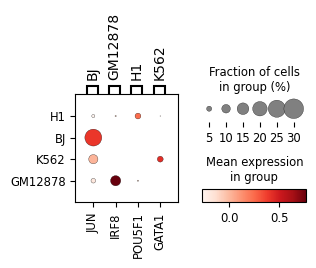

In [217]:
# Plot dotplot
sc.pl.dotplot(rna, markers, groupby="annotation")

In [218]:
del rna.obsp
del rna.varm
del rna.uns
rna

AnnData object with n_obs × n_vars = 1047 × 18666
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'annotation'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'log1p_norm', 'scaled'

In [219]:
rna.write(path_out + "rna_processed.h5ad")

# ATAC analysis

In [220]:
import snapatac2 as snap
from scipy.sparse import csr_matrix

In [ ]:
# Convert atac.X to sparse matrix from numpy array using scipy.sparse.csr_matrix
atac.X = csr_matrix(atac.X)

In [221]:
atac.layers["counts"] = atac.X.copy()

In [222]:
sc.pp.calculate_qc_metrics(atac, var_type="peaks", inplace=True)

In [223]:
snap.pp.select_features(
    atac, 
    n_features=10000000,
    blacklist="/cellar/users/aklie/data/ref/genomes/hg38/blacklist/ENCFF356LFX.bed.gz"
)

2024-05-19 14:45:38 - INFO - Selected 135302 features.


In [225]:
snap.tl.spectral(atac, random_state=1234)

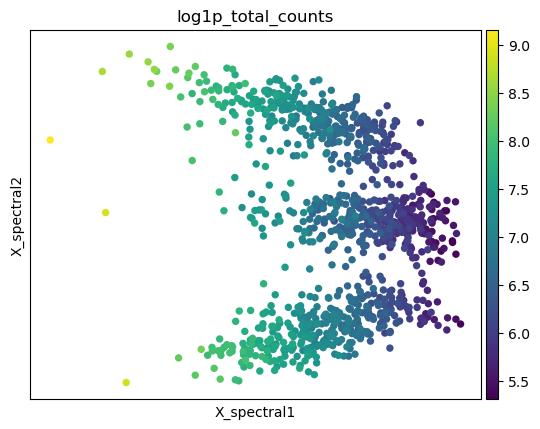

In [226]:
# Check first embedding 
sc.pl.embedding(atac, basis="X_spectral", color="log1p_total_counts")

In [185]:
#snap.pp.knn(atac, n_neighbors=10, use_dims=list(range(1, atac.obsm["X_spectral"].shape[1])), random_state=1234)

In [186]:
#snap.tl.leiden(atac, resolution=0.5, random_state=1234)

In [227]:
sc.pp.neighbors(atac, n_neighbors=10, use_rep="X_spectral", random_state=1234)

In [228]:
sc.tl.umap(atac, min_dist=0.1, spread=2.0, random_state=1234)

In [230]:
sc.tl.leiden(atac, resolution=0.5, random_state=1234)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


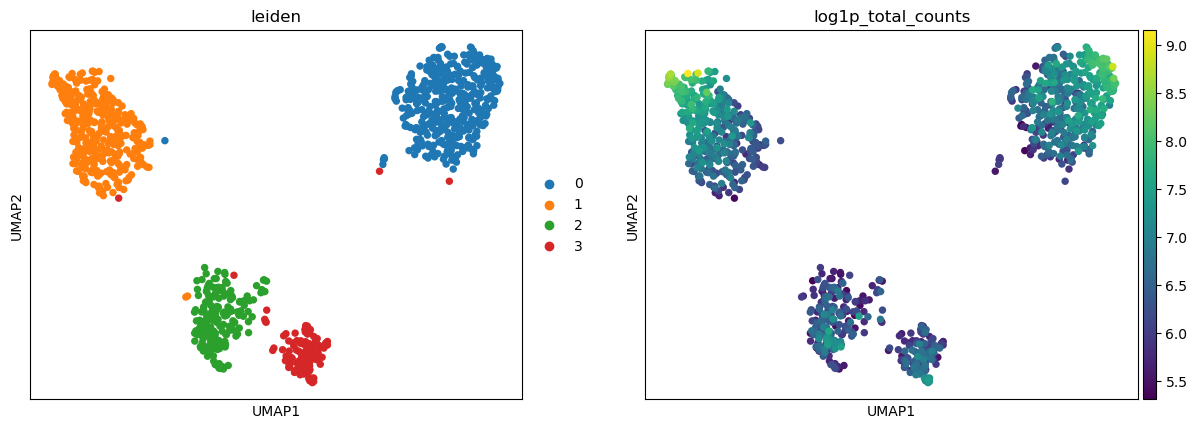

In [231]:
sc.pl.umap(atac, color=["leiden", 'log1p_total_counts'])

In [149]:
#snap.tl.umap(atac, random_state=1234)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [232]:
#sc.pl.umap(atac, color="leiden")

In [155]:
atac

AnnData object with n_obs × n_vars = 1047 × 136771
    obs: 'n_peaks_by_counts', 'log1p_n_peaks_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_peaks', 'pct_counts_in_top_100_peaks', 'pct_counts_in_top_200_peaks', 'pct_counts_in_top_500_peaks', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'count', 'selected'
    uns: 'spectral_eigenvalue', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_spectral', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [233]:
del atac.obsp
del atac.varm
del atac.uns
atac

AnnData object with n_obs × n_vars = 1047 × 136771
    obs: 'n_peaks_by_counts', 'log1p_n_peaks_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_peaks', 'pct_counts_in_top_100_peaks', 'pct_counts_in_top_200_peaks', 'pct_counts_in_top_500_peaks', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'count', 'selected'
    obsm: 'X_spectral', 'X_umap'
    layers: 'counts'

In [234]:
atac.write(path_out + "atac_processed.h5ad")

# MuData

In [3]:
import mudata as mu

In [2]:
# Path to processed
path_rna = "/cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/analysis/rna_processed.h5ad"
path_atac = "/cellar/users/aklie/data/datasets/Chen2019_cell-line-mixture_SNARE-seq/analysis/atac_processed.h5ad"

In [4]:
# Load processed AnnData objects
rna = ad.read_h5ad(path_rna)
atac = ad.read_h5ad(path_atac)

In [5]:
# Make a MuData object
mdata = mu.MuData({
    "rna": rna,
    "atac": atac
})

In [6]:
# Add cell line annotation to rna
mdata.obs["cell_line"] = rna.obs["annotation"].copy()

In [14]:
# Write MuData object
mdata.write(path_out + "processed.h5mu")

# DONE!

---

In [248]:
mdata = mu.read_h5mu("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/analysis/timecourse/A2_control/celloracle/2024_05_02/A2_control.h5mu")

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [249]:
mdata.mod["atac"]

AnnData object with n_obs × n_vars = 14090 × 407371
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'annotation', 'sample_id', 'sample_description', 'atac_library_id', 'rna_library_id', 'batch', 'timepoint', 'condition', 'leiden_0.2', 'leiden_0.5', 'leiden_0.8', 'leiden_1.0', 'leiden_1.5', 'wnn_leiden_0.5'
    var: 'count', 'selected'
    obsm: 'X_spectral', 'X_umap'
    layers: 'counts'